# Wine scoring prediction - version 2

In this version description and taster's data are excluded from the dataset. The purpose is that in real world scenario we probably wouldn't have those informations while trying to predict wine's rating.

In [88]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
data = pd.read_csv("./wine_dataset.csv", index_col="Unnamed: 0")

Before cleaning the data, we extract years from wine titles

In [90]:
yearSearch = []    
for value in data['title']:
    regexresult = re.search(r'19\d{2}|20\d{2}', value)
    if regexresult:
        yearSearch.append(int(regexresult.group()))
    else: 
        yearSearch.append(None)
        
data['year'] = yearSearch


## Data preprocessing

In [91]:
data = data.dropna(subset=['year'])
data = data[data['year']>=1990]
data = data[data['price']<200]

In [92]:
data = data.drop("region_2", axis=1)
data = data.drop("taster_twitter_handle", axis=1)
data = data.drop("designation", axis=1)
data = data.dropna(subset=['country', 'province', 'price'])

In [93]:
data[['region_1', 'taster_name']] = data[['region_1', 'taster_name']].fillna('Unknown')

In [94]:
#l_features = ['country','description', 'price', 'province', 'variety', 'taster_name', 'region_1', 'year', 'winery']
l_features = ['country', 'price', 'province', 'variety','year', 'region_1']
X_train, X_test, y_train, y_test = train_test_split(data[l_features], data['points'], test_size=0.1, random_state=42)

In [95]:
#ohe = OneHotEncoder(cols=['country', 'year', 'province', 'taster_name']).fit(X_train)
ohe = OneHotEncoder(cols=['country', 'year', 'province', 'variety', 'region_1']).fit(X_train)
X_train = ohe.transform(X_train)
X_test= ohe.transform(X_test)

/home/bartek/anaconda3/envs/ds/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [96]:
X_train['price'] = np.log(X_train['price'])
X_test['price'] = np.log(X_test['price'])

## Model creation

In [97]:
#regression = RandomForestRegressor()
regression = Ridge()
#regression.fit(X_train.drop(['province', 'region_1', 'variety', 'winery'], axis=1), y_train)
regression.fit(X_train, y_train)

Ridge()

## Performance evaluation

In [98]:
pred_test = regression.predict(X_test)
#pred_test = regression.predict(X_test.drop('price', axis=1))
pred_test = pd.Series(pred_test)
y_test = pd.Series(y_test)
pred_test = pd.Series(pred_test)

In [99]:
error = pred_test.reset_index() - y_test.reset_index()

In [100]:
rmse = mean_squared_error(pred_test, y_test.astype(float), squared=False)
mse = mean_squared_error(pred_test, y_test.astype(float))
mae = mean_absolute_error(pred_test, y_test.astype(float))
print("Mean absolute error: " + str(mae))
print("Mean squared error: " + str(mse))
print("Root mean squared error: " + str(rmse))



Mean absolute error: 1.8628633385987732
Mean squared error: 5.441231959005273
Root mean squared error: 2.332644842020592


In [101]:
y_test.index = range(len(y_test))
error = y_test.astype(float) - pred_test.astype(float)

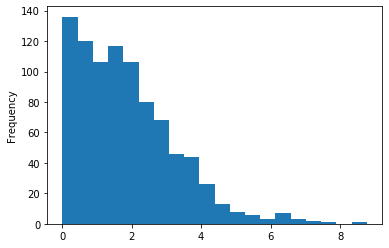

In [102]:
error.abs().plot.hist(bins=20)

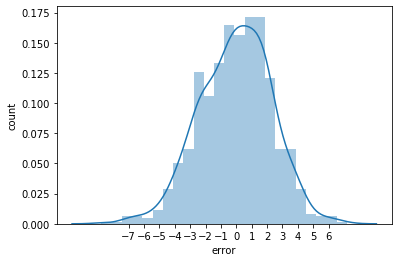

In [103]:
g = sns.distplot(error)
g.set_xticks(range(-7,7,1)); # <--- set the ticks first
g.set(xlabel='error', ylabel='count')

g.get_figure().savefig("output.png")

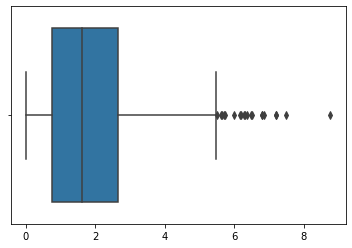

In [104]:
ax = sns.boxplot(x=error.abs())

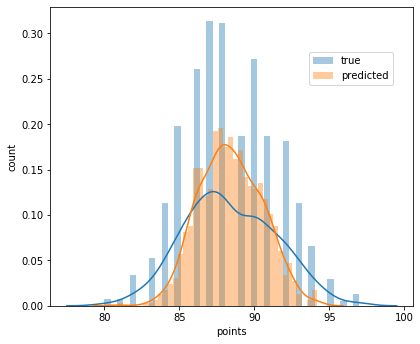

In [105]:
fig, ax = plt.subplots(figsize=(6.5,5.5))
for a in [y_test, pred_test]:
    sns.distplot(a, bins=40, ax=ax)
fig.legend(labels=['true','predicted'], bbox_to_anchor=(0.85, 0.75))
ax.set(xlabel='points', ylabel='count')
plt.savefig('predicted_and_true.png')

## Most important features

In [106]:
features = X_test.columns
importance = regression.coef_
zipped = zip(features, importance)
dictionary = dict(zipped)

In [107]:
{k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1], reverse=True)}

{'province_75': 3.2655571245149746,
 'region_1_288': 2.9647295987248783,
 'price': 2.9202811308402863,
 'region_1_137': 2.8481018939496723,
 'region_1_580': 2.8290029593337707,
 'variety_106': 2.6610778460215894,
 'variety_56': 2.4841368373745634,
 'variety_88': 2.4315016677409584,
 'variety_204': 2.365418785128962,
 'region_1_409': 2.345468481599835,
 'region_1_330': 2.208849521002087,
 'region_1_613': 2.1900708657073182,
 'region_1_318': 2.1137727670882023,
 'region_1_325': 2.0600278950212796,
 'region_1_341': 2.0411495995728632,
 'region_1_344': 2.0243204541617854,
 'region_1_489': 1.996264319249834,
 'variety_142': 1.9333009951501634,
 'region_1_389': 1.9174446247659165,
 'province_112': 1.9165193927930404,
 'region_1_637': 1.9034412506504932,
 'variety_265': 1.8708927030014448,
 'variety_206': 1.869815963703935,
 'variety_97': 1.8680807063930174,
 'region_1_355': 1.8533758157459816,
 'variety_149': 1.8522335853907324,
 'region_1_224': 1.8505858804955546,
 'region_1_493': 1.8259962